In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import os

In [2]:
binning =2 
chess_shape = (5, 7) # row, column
# cam_shape = (1536//binning, 2048//binning) # row, column
cam_shape = (580,890)
chess_block_size = 24.0
# dat_path = './data/camera/20201118_5/'
dat_path = './experiments/white_image/'


In [3]:

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
criteria_cal = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)

objp = np.zeros((chess_shape[0]*chess_shape[1], 3), np.float32)
objp[:, :2] = chess_block_size*np.mgrid[0:chess_shape[1], 0:chess_shape[0]].T.reshape(-1, 2)
# Arrays to store object points and image points from all the images.

In [4]:
gc_fnames = sorted(glob.glob(os.path.join(dat_path, '*.png')))
print('--- found %s images ---'%len(gc_fnames))
print(gc_fnames)

--- found 11 images ---
['./experiments/white_image\\white_0000.png', './experiments/white_image\\white_0001.png', './experiments/white_image\\white_0002.png', './experiments/white_image\\white_0003.png', './experiments/white_image\\white_0004.png', './experiments/white_image\\white_0005.png', './experiments/white_image\\white_0006.png', './experiments/white_image\\white_0007.png', './experiments/white_image\\white_0008.png', './experiments/white_image\\white_0009.png', './experiments/white_image\\white_0010.png']


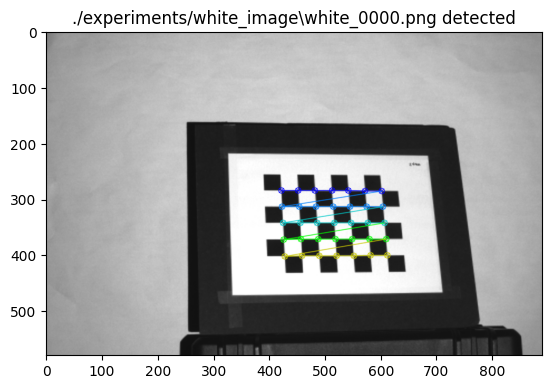

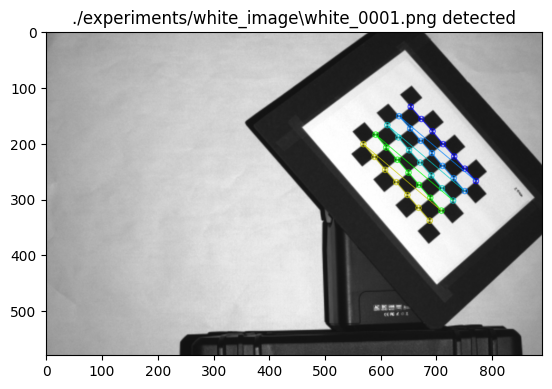

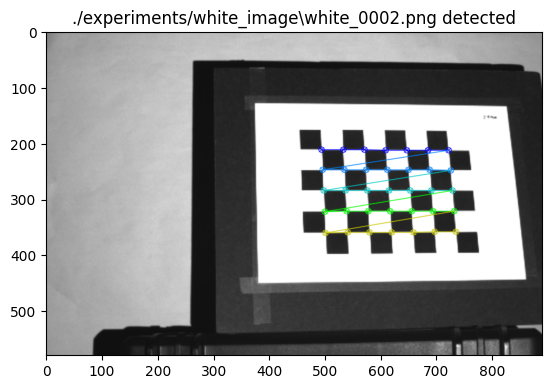

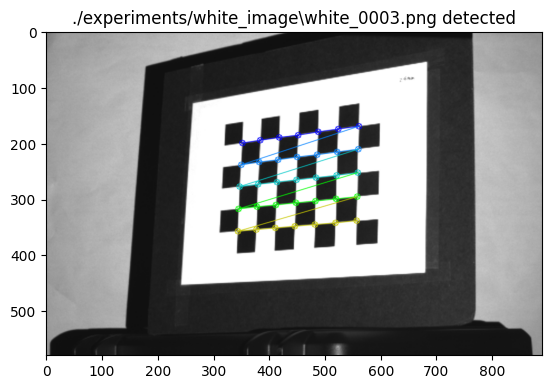

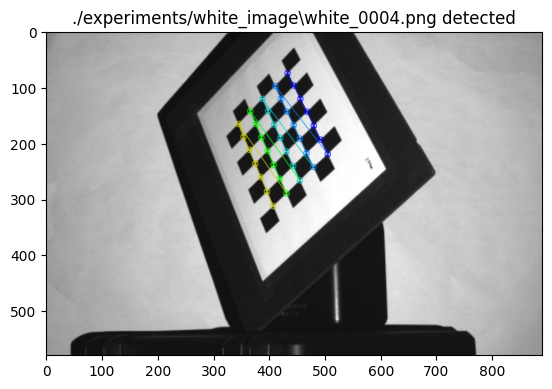

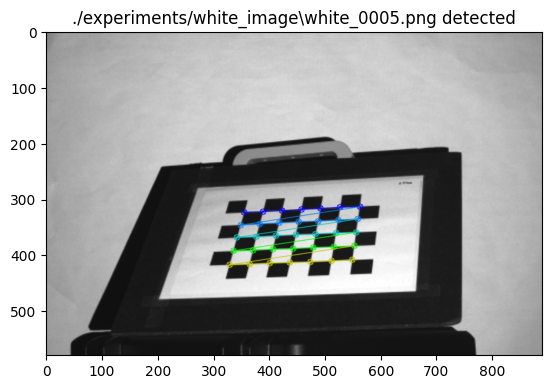

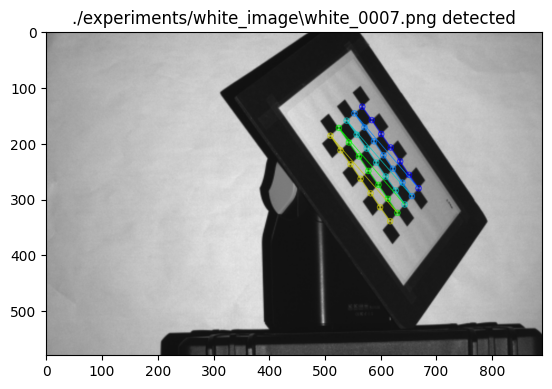

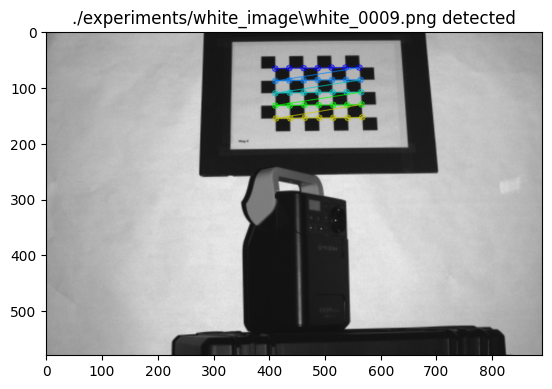

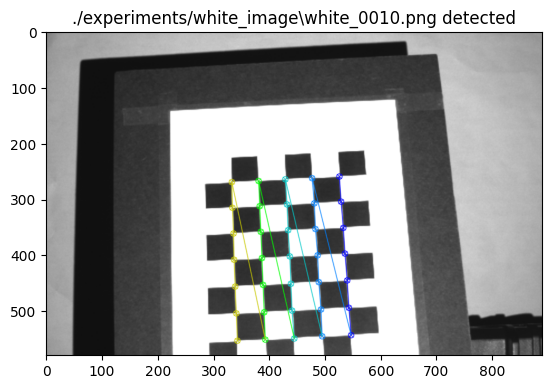

9/11 images are valid


In [5]:
objpoints = []  # 3d point in real world space
imgpoints_l = []  # 2d points in image plane.

for i in range(len(gc_fnames)):

    path_l = gc_fnames[i]

    im_l = cv2.imread(path_l)

    # checker to the image
    # im_l = polargrid2polarbayer(im_l)

    gray_l = cv2.cvtColor(im_l, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret_l, corners_l = cv2.findChessboardCorners(gray_l, chess_shape[::-1], None, flags=cv2.CALIB_CB_FILTER_QUADS)

    # If found, add object points, image points (after refining them)
    if ret_l:
        objpoints.append(objp)

        corners2_l = cv2.cornerSubPix(gray_l, corners_l, (11, 11), (-1, -1), criteria)

        imgpoints_l.append(corners2_l)

        # Draw corners and save image
        img_drawn_l = cv2.drawChessboardCorners(np.stack([gray_l,gray_l,gray_l],-1), chess_shape[::-1], corners2_l, ret_l)
        plt.imshow(img_drawn_l)
        plt.title('%s detected'%path_l)
        plt.show()
#     else:
#         plt.imshow(im_l)
#         plt.title('%d undetected'%i)
#         plt.show()
print('%d/%d images are valid'%(len(imgpoints_l),len(gc_fnames)))

In [6]:
print('Initial solution of camera\'s intrinsic parameters')
cam_rvecs = []
cam_tvecs = []
ret, cam_int, cam_dist, cam_rvecs, cam_tvecs = cv2.calibrateCamera(objpoints, imgpoints_l, cam_shape, None, None, None, None)
print('  RMS :', ret)
print('  Intrinsic parameters :')
print(cam_int, '    ')
print('  Distortion parameters :')
print(cam_dist, '    ')
print()

Initial solution of camera's intrinsic parameters
  RMS : 0.22521362809746837
  Intrinsic parameters :
[[1.73638008e+03 0.00000000e+00 4.15767412e+02]
 [0.00000000e+00 1.75272317e+03 3.99091693e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]     
  Distortion parameters :
[[-6.11166052e-01  8.93769858e+00 -3.70822707e-03  6.61390235e-03
  -1.01260267e+02]]     



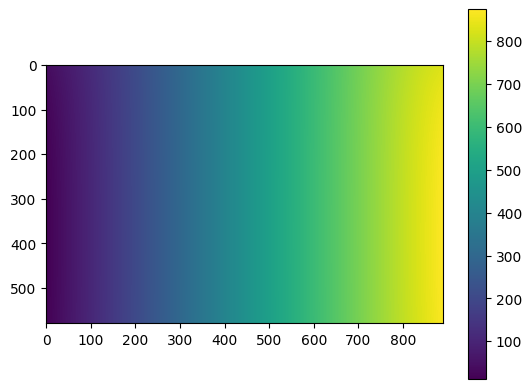

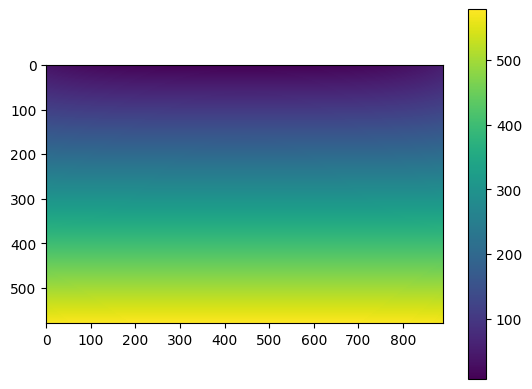

In [7]:
import numpy as np
np.eye(3)

mapx, mapy = cv2.initUndistortRectifyMap(cam_int, cam_dist, np.eye(3), cam_int, cam_shape[::-1], cv2.CV_32FC1)
plt.imshow(mapx)
plt.colorbar()
plt.show()
plt.imshow(mapy)
plt.colorbar()

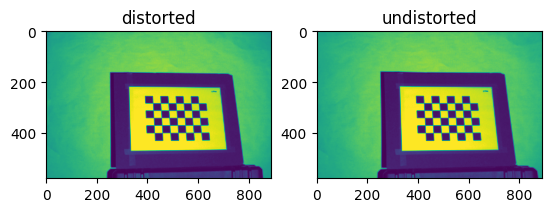

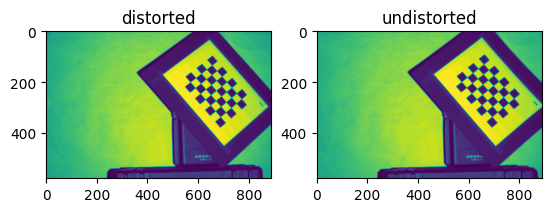

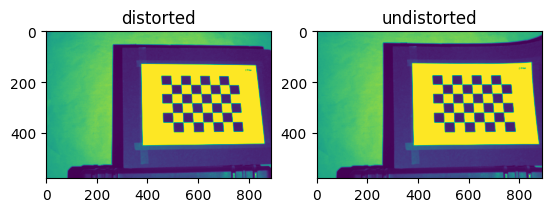

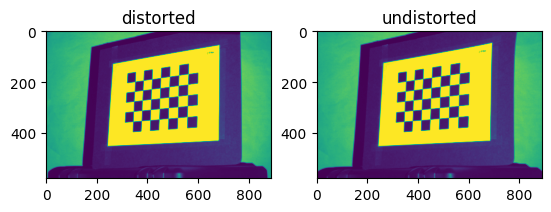

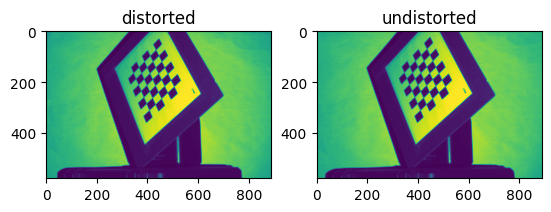

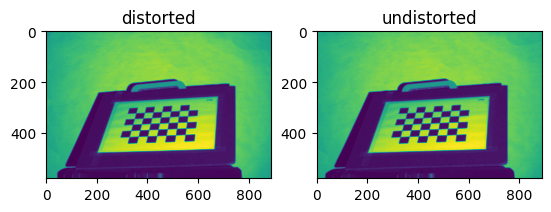

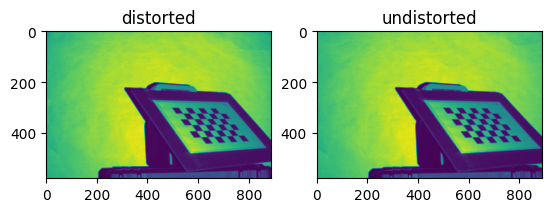

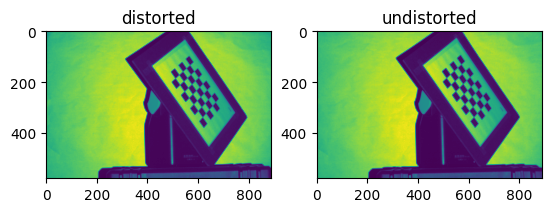

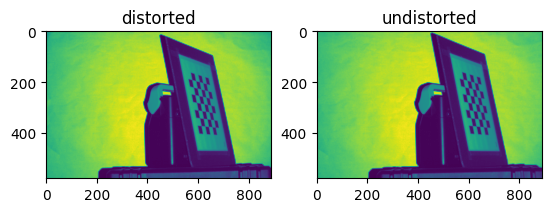

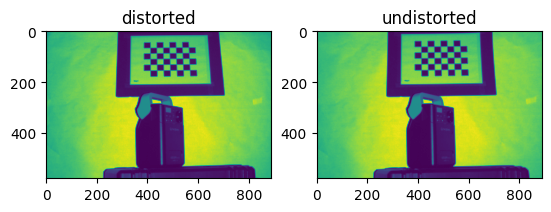

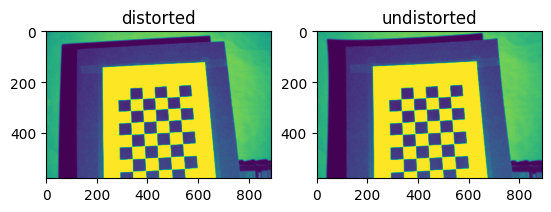

In [8]:
for i in range(len(gc_fnames)):
    
    path_l = gc_fnames[i]

    im_l = cv2.imread(path_l)
    # im_l = polargrid2polarbayer(im_l)

    gray_l = cv2.cvtColor(im_l, cv2.COLOR_BGR2GRAY)
    
    # undistort
    dst = cv2.undistort(gray_l, cam_int, cam_dist, None)
    
    plt.subplot(121)
    plt.imshow(gray_l)
    plt.title('distorted')
    plt.subplot(122)
    plt.imshow(dst)
    plt.title('undistorted')
    plt.show()

In [9]:
print('Initial solution of camera\'s intrinsic parameters')
cam_rvecs = []
cam_tvecs = []
ret, cam_int, cam_dist, cam_rvecs, cam_tvecs = cv2.calibrateCamera(objpoints, imgpoints_l, cam_shape, None, None, None, None)
print('  RMS :', ret)
print('  Intrinsic parameters :')
print(cam_int, '    ')
print('  Distortion parameters :')
print(cam_dist, '    ')
print()

Initial solution of camera's intrinsic parameters
  RMS : 0.22521362809746837
  Intrinsic parameters :
[[1.73638008e+03 0.00000000e+00 4.15767412e+02]
 [0.00000000e+00 1.75272317e+03 3.99091693e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]     
  Distortion parameters :
[[-6.11166052e-01  8.93769858e+00 -3.70822707e-03  6.61390235e-03
  -1.01260267e+02]]     



In [10]:
fn_out = 'calibration_pcam.xml'
print('save the calibrated data to %s'%fn_out)
fs = cv2.FileStorage(fn_out, cv2.FILE_STORAGE_WRITE)
fs.write('img_shape', cam_shape)
fs.write('rms', ret)
fs.write('cam_int', cam_int)
fs.write('cam_dist', cam_dist)
fs.write('mapx', mapx)
fs.write('mapy', mapy)
fs.release()

save the calibrated data to calibration_pcam.xml
